# Assignment 1
**Credits**: Leonardo Chiarioni, Shariq Mohd Ansari, Federico Faccioli

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Introduction

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

## 0. Importing useful packages

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from typing import Dict, List
plt.style.use('ggplot')

In [2]:
try:
    import google.colab
    path_test = "/content/test.json"
    path_training = "/content/training.json"
    path_val = "/content/validation.json"
    print("Using Colab!")

    !pip install transformers
    !pip install datasets
    !pip install accelerate -U
    !pip install evaluate
    !pip install bitsandbytes
    !pip install contractions
except ImportError:
    path_test = "data\\test.json"
    path_training = "data\\training.json"
    path_val = "data\\validation.json"
    print("Not using Colab :(")

Not using Colab :(


In [3]:
# Let's make our experiments reproducible with this function.
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)  # sets seeds for base-python, numpy and tf
    tf.config.experimental.enable_op_determinism()
fix_random(42)

## 1. Dataset
### Studying the data.
Are there any missing values?

In [4]:
df_train = pd.read_json(path_training).transpose()
df_val = pd.read_json(path_val).transpose()
df_test = pd.read_json(path_test).transpose()

df_train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [5]:
df_train.describe()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
count,6920,6920,6920,6920,6920,6920,6920,6920,6920,6920,6920
unique,6920,2,6920,1,123,2,2,64,1982,4090,2
top,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
freq,1,3660,1,6920,57,3660,3660,1434,1434,1434,3660


In [6]:
df_val.describe()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
count,726,726,726,726,726,726,726,726,726,726,726
unique,726,2,726,1,19,1,1,62,406,517,2
top,300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
freq,1,549,1,726,57,726,726,139,139,139,549


In [7]:
df_test.describe()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
count,312,312,312,312,312,312,312,312,312,312,312
unique,312,1,312,1,9,1,1,57,191,231,1
top,400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
freq,1,312,1,312,44,312,312,64,64,64,312


### Cleaning the data.
1. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
2. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
3. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
4. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [8]:
def compute_hard_label(soft_labels: list) -> str:
    """Compute the hard label from a list of soft labels.
    """
    hard_label = 1 if soft_labels.count('YES') > soft_labels.count('NO') else 0
    hard_label = None if soft_labels.count('YES') == soft_labels.count('NO') else hard_label
    return hard_label


In [9]:
df_train['hard_label_task1'] = df_train['labels_task1'].apply(compute_hard_label)
df_val['hard_label_task1'] = df_val['labels_task1'].apply(compute_hard_label)
df_test['hard_label_task1'] = df_test['labels_task1'].apply(compute_hard_label)

df_train.head()


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,1.0
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,0.0
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,0.0
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,NaN
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,1.0


In [ ]:
# Dropping rows with None hard labels
df_train_filtered = df_train.dropna(subset=['hard_label_task1'], inplace=False)
df_val_filtered = df_val.dropna(subset=['hard_label_task1'], inplace=False)
df_test_filtered = df_test.dropna(subset=['hard_label_task1'], inplace=False)

df_train_filtered['hard_label_task1'] = df_train_filtered['hard_label_task1'].astype(np.int32)
df_val_filtered['hard_label_task1'] = df_val_filtered['hard_label_task1'].astype(np.int32)
df_test_filtered['hard_label_task1'] = df_test_filtered['hard_label_task1'].astype(np.int32)

train_drop = len(df_train) - len(df_train_filtered)
val_drop = len(df_val) - len(df_val_filtered)
test_drop = len(df_test) - len(df_test_filtered)

print(f"Number of dropped rows in training set: {train_drop}")
print(f"Number of dropped rows in validation set: {val_drop}")
print(f"Number of dropped rows in test set: {test_drop}")

Number of dropped rows in training set: 856
Number of dropped rows in validation set: 78
Number of dropped rows in test set: 26


In [96]:
df_train_filtered.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,1
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,0
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,0
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,1
100006,100006,es,@yonkykong Aaah sí. Andrew Dobson. El que se d...,6,"[Annotator_25, Annotator_26, Annotator_27, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,0


In [97]:
# dropping those rows whose lang column is 'es'

train_drop = len(df_train_filtered)
val_drop = len(df_val_filtered)
test_drop = len(df_test_filtered)

df_train_filtered = df_train_filtered[df_train_filtered['lang'] == 'en']
df_val_filtered = df_val_filtered[df_val_filtered['lang'] == 'en']
df_test_filtered = df_test_filtered[df_test_filtered['lang'] == 'en']

train_drop -= len(df_train_filtered)
val_drop -= len(df_val_filtered)
test_drop -= len(df_test_filtered)

print(f"Number of dropped rows in training set: {train_drop}")
print(f"Number of dropped rows in validation set: {val_drop}")
print(f"Number of dropped rows in test set: {test_drop}")

Number of dropped rows in training set: 3194
Number of dropped rows in validation set: 490
Number of dropped rows in test set: 0


In [98]:
# dropping useless columns
columns_to_drop = ['number_annotators','annotators','gender_annotators','age_annotators','labels_task1','labels_task2','labels_task3','split']
df_train_filtered.drop(columns=columns_to_drop, inplace=True)
df_val_filtered.drop(columns=columns_to_drop, inplace=True)
df_test_filtered.drop(columns=columns_to_drop, inplace=True)

In [99]:
df_train_filtered.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


### Plotting label distribution of the dataset.
Now that we have a clean dataset let's study the label distribution. Is there an imbalance?

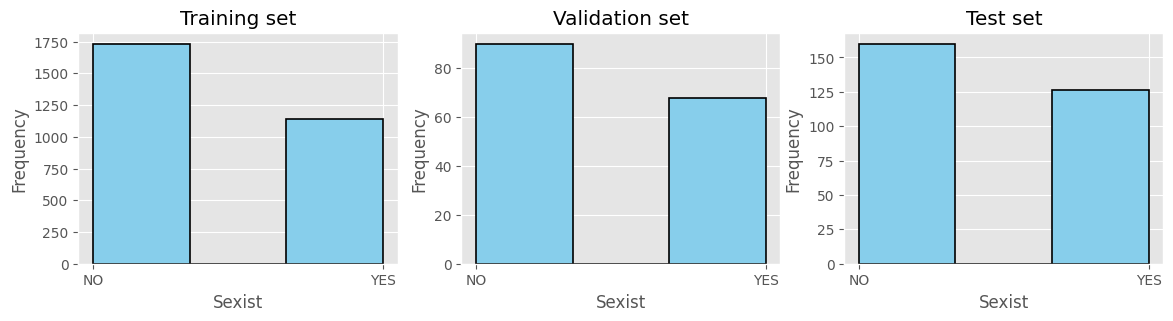

In [101]:
def plot_distribution(datasets: List[pd.DataFrame], titles: List[str]) -> None:
    _, axs = plt.subplots(1, len(datasets), figsize=(14, 3))

    for i, dataset in enumerate(datasets):
        axs[i].hist(dataset['hard_label_task1'], bins=3, color='skyblue', edgecolor='black', linewidth=1.2)
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Sexist')
        axs[i].set_ylabel('Frequency')
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['NO', 'YES'])

    plt.show()

plot_distribution([df_train_filtered, df_val_filtered, df_test_filtered], ['Training set', 'Validation set', 'Test set'])



The dataset is a bit umbalanced. This may cause problems in general applications: in the real world, hopefully, most of the tweets should not be sexist :D.  
All of the splits present the same umbalance (same label distribution), so this should not be a real threat.

## 2. Text preprocessing
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.


### Processing the text.
We will clean the text from special characters, standardize contractions and transform special words according to:
- **Standardize contractions** (e.g., can't -> can not)
- **Substitute emojis** with \<EMOJI\>.
- **Substitute hashtags** with \<HASHTAG\>.
- **Substitue mentions** with \<USER\>.
- **Substitute URLs** with \<URL\>.
- **Substitute Numbers** with \<NUMBER\>.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.
- **Remove stopwords** from the text.

In [102]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

[nltk_data] Downloading package omw-1.4 to C:\Users\Leonardo
[nltk_data]     Chiarioni\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Leonardo
[nltk_data]     Chiarioni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Leonardo
[nltk_data]     Chiarioni\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Leonardo
[nltk_data]     Chiarioni\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [103]:
import re
from gensim.parsing.preprocessing import remove_stopwords
import contractions

def preprocess_text(text, lowercase=True, include_stopwords=True, lemmatize=True): 
    emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F700-\U0001F77F"  # Alchemical Symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols & Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002700-\U000027BF"  # Dingbats
    "\U000024C2-\U0001F251"  # Enclosed characters
    "]+",
    flags=re.UNICODE,
)
    url_pattern = re.compile(r"http\S+")
    hashtag_pattern = re.compile(r"#\S+")
    mention_pattern = re.compile(r"@\S+")
    special_char_pattern = re.compile(r"&\S+")
    number_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    negation_pattern = re.compile(r"\b(\w+)n't\b")
    single_quote_pattern = re.compile(r"[‘’`]")
    double_quote_pattern = re.compile(r'[“”]')

    text = text.lower() if lowercase else text
    text = url_pattern.sub(" <URL> ", text)
    text = hashtag_pattern.sub(" <HASHTAG> ", text)
    text = mention_pattern.sub(" <USER> ", text)
    text = emoji_pattern.sub(" <EMOJI> ", text)
    text = special_char_pattern.sub("", text)
    text = number_pattern.sub(" <NUMBER> ", text)
    text = single_quote_pattern.sub("'", text)
    text = double_quote_pattern.sub('"', text)
    text = contractions.fix(text)
    text = negation_pattern.sub(r"\1nt", text)
    text = remove_stopwords(text) if not include_stopwords else text
    text = re.sub(r"[^A-Za-z<> ]+", " ", text)
    text = re.sub(r'\s+', ' ', text) # to remove redundant whitespaces
    text = lem_text(text) if lemmatize else text
    return text.strip()

### Cleaning the tweets:
#### We will consider 3 different processed text:
- lemmatization of the tweet ('lemmatized_tweet');
- stopwords removal and lemmatization of the tweet ('lemmatized_no_stopwords_tweet');
- No further processing ('simple_processed_tweet').

In [104]:
df_train_filtered['lemmatized_tweet'] = df_train_filtered['tweet'].apply(preprocess_text,
                                                                         lowercase=True,
                                                                         include_stopwords=True,
                                                                         lemmatize=True)
df_val_filtered['lemmatized_tweet'] = df_val_filtered['tweet'].apply(preprocess_text,
                                                                     lowercase=True,
                                                                     include_stopwords=True,
                                                                     lemmatize=True)
df_test_filtered['lemmatized_tweet'] = df_test_filtered['tweet'].apply(preprocess_text,
                                                                       lowercase=True,
                                                                       include_stopwords=True,
                                                                       lemmatize=True)

In [105]:
df_train_filtered['lemmatized_no_stopwords_tweet'] = df_train_filtered['tweet'].apply(preprocess_text,
                                                                         lowercase=True,
                                                                         include_stopwords=False,
                                                                         lemmatize=True)
df_val_filtered['lemmatized_no_stopwords_tweet'] = df_val_filtered['tweet'].apply(preprocess_text,
                                                                     lowercase=True,
                                                                     include_stopwords=False,
                                                                     lemmatize=True)
df_test_filtered['lemmatized_no_stopwords_tweet'] = df_test_filtered['tweet'].apply(preprocess_text,
                                                                       lowercase=True,
                                                                       include_stopwords=False,
                                                                       lemmatize=True)

In [106]:
df_train_filtered['simple_processed_tweet'] = df_train_filtered['tweet'].apply(preprocess_text,
                                                                        lowercase=True,
                                                                        include_stopwords=True,
                                                                        lemmatize=False)
df_val_filtered['simple_processed_tweet'] = df_val_filtered['tweet'].apply(preprocess_text,
                                                                        lowercase=True,
                                                                        include_stopwords=True,
                                                                        lemmatize=False)
df_test_filtered['simple_processed_tweet'] = df_test_filtered['tweet'].apply(preprocess_text,
                                                                        lowercase=True,
                                                                        include_stopwords=True,
                                                                        lemmatize=False)

In [107]:
df_train_filtered.head()

,id_EXIST,lang,tweet,hard_label_task1,lemmatized_tweet,lemmatized_no_stopwords_tweet,simple_processed_tweet
200002,200002,en,Writing a uni essay in my local pub with a cof...,1,write a uni essay in my local pub with a coffe...,write uni essay local pub coffee random old ma...,writing a uni essay in my local pub with a cof...
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1,<USER> it be <NUMBER> not <NUMBER> i do not ap...,<USER> <NUMBER> <NUMBER> appreciate ride team ...,<USER> it is <NUMBER> not <NUMBER> i do not ap...
200006,200006,en,According to a customer I have plenty of time ...,1,accord to a customer i have plenty of time to ...,accord customer plenty time spend stirling coi...,according to a customer i have plenty of time ...
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1,so only blokes drink beer sorry but if you be ...,bloke drink beer sorry bloke drink wine appare...,so only blokes drink beer sorry but if you are...
200008,200008,en,New to the shelves this week - looking forward...,0,new to the shelf this week look forward to rea...,new shelf week look forward read book <USER> <...,new to the shelves this week looking forward t...


In [108]:
id = 13
print(f"original: {df_train_filtered['tweet'].iloc[id]}")
print(f"lemmatized: {df_train_filtered['lemmatized_tweet'].iloc[id]}")
print(f"lemmatized with no stopwords: {df_train_filtered['lemmatized_no_stopwords_tweet'].iloc[id]}")
print(f"simple processed: {df_train_filtered['simple_processed_tweet'].iloc[id]}")

original: Why do we create comics about sexism in science? It’s not just because we have a lot of spare time or like to doodle… Check out our blog post for @EuroGeosciences #EGUblogs #EGU22 #DidThisReallyHappen #DTHR #EverydaySexism https://t.co/XFHSn0VKs2
lemmatized: why do we create comic about sexism in science it be not just because we have a lot of spare time or like to doodle check out our blog post for <USER> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <URL>
lemmatized with no stopwords: create comic sexism science lot spare time like doodle check blog post <USER> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <URL>
simple processed: why do we create comics about sexism in science it is not just because we have a lot of spare time or like to doodle check out our blog post for <USER> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <URL>


## 3. Text Encoding
To train a neural sexism classifier, we first need to encode text into numerical format.




### Building the vocabulary
We will encode our vocabulary with GloVE encoding, by adding OOV terms and **initializing** them with **random values**.  
Since the vocabulary is built from the training set, we might find **unseen word** during evaluation. For this reason we need to handle **a special token "[UNK]"**, which will be assigned with an embedding of all zeros.  
We will build the vocabulary with indexes starting from 1, leaving the index zero for the token representing the padding "[PAD]".  
This is done to ensure that we can use an embedding layer that can **ignore padded word (with index 0)**

In [109]:
from collections import OrderedDict

def build_vocabulary(df: pd.DataFrame, tweet_column: str) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 1
    for sentence in tqdm(df[tweet_column].values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing


def evaluate_vocabulary(idx_to_word: Dict[int, str], word_to_idx: Dict[str, int],
                        word_listing: List[str], df: pd.DataFrame, tweet_column: str, check_default_size: bool = False):
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(1, len(idx_to_word)+1)):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df, tweet_column)
    _, _, second_word_listing = build_vocabulary(df, tweet_column)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        tweet_column: ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df, tweet_column)
    toy_valid_vocabulary = set(' '.join(toy_df[tweet_column].values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary


In [110]:
import gensim
import gensim.downloader as gloader

def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"
    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32) # +1 for the padding token

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            # creating custom embedding for oov words
            if word == '[UNK]':
                embedding_vector = np.zeros(embedding_dimension)
            else:
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector # idx and not -1, because otherwise we map every token to a wrong index
        # the embedding matrix will have a representation also for the [PAD] token, even tho is handlet automatically by the embedding layer

    return embedding_matrix

In [112]:
def add_tokens_to_vocabulary(word_listing: List[str], idx_to_word: Dict[int, str], word_to_idx: Dict[str, int]):
    """
    Adds [UNK] and [PAD] tokens to the vocabulary, needed for building the embedding matrix.

    :param word_listing: list of unique terms that build up the vocabulary
    :param idx_to_word: vocabulary index to word
    :param word_to_idx: word to vocabulary index
    """
    word_listing.append('[UNK]')
    idx_to_word[len(word_listing)] = '[UNK]'
    word_to_idx['[UNK]'] = len(word_listing)

    word_listing[0:0] = ['[PAD]']
    idx_to_word[0] = '[PAD]'
    word_to_idx['[PAD]'] = 0

Loading the GloVe embedding model. Choosing 50 as embedding dimension.

In [113]:
embedding_model = load_embedding_model(model_type='glove', embedding_dimension=50)

### Let's build the vocabularies for each of the different processing technique, and then see their sizes and oov_term percentages
#### Lemmatized vocabulary

In [114]:
idx_to_word_lem, word_to_idx_lem, word_listing_lem = build_vocabulary(df_train_filtered, 'lemmatized_tweet')
oov_terms_lem = check_OOV_terms(embedding_model, word_listing_lem)
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_lem, word_to_idx_lem, word_listing_lem, df_train_filtered, 'lemmatized_tweet')
print("Evaluation completed!")
print("")
print(f"[Debug] Length of the vocabulary for LEMMATIZED tweets: {len(idx_to_word_lem)}")
oov_percentage = float(len(oov_terms_lem)) * 100 / len(word_listing_lem)
print(f"Total OOV terms: {len(oov_terms_lem)} ({oov_percentage:.2f}%)")

  0%|          | 0/2870 [00:00<?, ?it/s]

100%|██████████| 2870/2870 [00:00<00:00, 48554.58it/s]


Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 8735/8735 [00:00<00:00, 686039.35it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:00<00:00, 70547.45it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<?, ?it/s]


Evaluation completed!

[Debug] Length of the vocabulary for LEMMATIZED tweets: 8735
Total OOV terms: 842 (9.64%)


#### Lemmatized with no stopwords vocabulary

In [115]:
idx_to_word_no_stop, word_to_idx_no_stop, word_listing_no_stop = build_vocabulary(df_train_filtered, 'lemmatized_no_stopwords_tweet')
oov_terms_no_stop = check_OOV_terms(embedding_model, word_listing_no_stop)
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_no_stop, word_to_idx_no_stop, word_listing_no_stop, df_train_filtered, 'lemmatized_no_stopwords_tweet')
print("Evaluation completed!")
print("")
print(f"[Debug] Length of the vocabulary for LEMMATIZED tweets with NO STOPWORDS: {len(idx_to_word_no_stop)}")
oov_percentage = float(len(oov_terms_no_stop)) * 100 / len(word_listing_no_stop)
print(f"Total OOV terms: {len(oov_terms_no_stop)} ({oov_percentage:.2f}%)")

100%|██████████| 2870/2870 [00:00<00:00, 82338.57it/s]


Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 8728/8728 [00:00<00:00, 705884.68it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:00<00:00, 38020.32it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 361.62it/s]

Evaluation completed!

[Debug] Length of the vocabulary for LEMMATIZED tweets with NO STOPWORDS: 8728
Total OOV terms: 844 (9.67%)


#### Simple processed vocabulary

In [116]:
idx_to_word_simple, word_to_idx_simple, word_listing_simple = build_vocabulary(df_train_filtered, 'simple_processed_tweet')
oov_terms_simple = check_OOV_terms(embedding_model, word_listing_simple)
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_simple, word_to_idx_simple, word_listing_simple, df_train_filtered, 'simple_processed_tweet')
print("Evaluation completed!")
print("")
print(f"[Debug] Length of the vocabulary for SIMPLE PROCESSED tweets: {len(idx_to_word_simple)}")
oov_percentage = float(len(oov_terms_simple)) * 100 / len(word_listing_simple)
print(f"Total OOV terms: {len(oov_terms_simple)} ({oov_percentage:.2f}%)")

100%|██████████| 2870/2870 [00:00<00:00, 26112.55it/s]


Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 10493/10493 [00:00<00:00, 273340.53it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:00<00:00, 35839.36it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<?, ?it/s]

Evaluation completed!

[Debug] Length of the vocabulary for SIMPLE PROCESSED tweets: 10493
Total OOV terms: 845 (8.05%)


### What are the differences between the out of vocabulary words?

In [34]:
print(set(oov_terms_lem).difference(set(oov_terms_no_stop)))
print(set(oov_terms_lem).difference(set(oov_terms_simple)))
print(set(oov_terms_no_stop).difference(set(oov_terms_lem)))
print(set(oov_terms_no_stop).difference(set(oov_terms_simple)))
print(set(oov_terms_simple).difference(set(oov_terms_lem)))
print(set(oov_terms_simple).difference(set(oov_terms_no_stop)))


{'bemuse'}
{'traumatise', 'cooky', 'catcall', 'enamor', 'weightlift', 'overfeed', 'stinkpot', 'bemuse', 'sequela', 'whop', 'blither', 'cheerlead', 'reify', 'becloud'}
{'sloganeer', 'dishevel', 'anglicise'}
{'dishevel', 'traumatise', 'cooky', 'becloud', 'catcall', 'enamor', 'weightlift', 'overfeed', 'sloganeer', 'stinkpot', 'sequela', 'whop', 'blither', 'cheerlead', 'reify', 'anglicise'}
{'catcalling', 'yess', 'purebloods', 'ravels', 'reifying', 'sexualizing', 'stinkpots', 'dumbasses', 'queering', 'beclouded', 'farted', 'spankers', 'traumatising', 'pursueing', 'shitting', 'bannisters', 'unboxing'}
{'catcalling', 'yess', 'purebloods', 'ravels', 'reifying', 'sexualizing', 'stinkpots', 'dumbasses', 'queering', 'beclouded', 'farted', 'spankers', 'traumatising', 'pursueing', 'shitting', 'bannisters', 'unboxing'}


Since the text has gone under slitghly different preocessing techniques, it is normal to have different words out of vocabulary. We can see that the vocabulary obtained with simple processing has a lot of words that ends with 'ing' and 'ed'! Lemmatization helped in truncating them to a base form of the word.  
The number of the OOV words is quite similar; we notice a reduction in percentage in the simple processed text, because the size of vocabulary increased.

In [147]:
special_tokens = ["<URL>", "<HASHTAG>","<USER>","<NUMBER>","<EMOJI>","[UNK]","[PAD]"]

Before encoding our vocabulary, we need to add the [UNK] token to map the possible unknown words present in the unseen datasets.  
For reasons that will be clear later, we also need to encode the [PAD] token. This is mainly due to coherency reasons in our vocabulary.

In [36]:
add_tokens_to_vocabulary(word_listing_lem, idx_to_word_lem, word_to_idx_lem)
add_tokens_to_vocabulary(word_listing_no_stop, idx_to_word_no_stop, word_to_idx_no_stop)
add_tokens_to_vocabulary(word_listing_simple, idx_to_word_simple, word_to_idx_simple)

It is now the time to encode our vocabulary with GloVE embedding. Since we have used 3 different processing techniques, we need to build 3 different embedding matrices!  
We will use an embedding dimension = 50

In [37]:
embedding_dimension = 50

In [38]:
embedding_matrix_lem = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx_lem, len(word_to_idx_lem), oov_terms_lem)
print(f"Embedding matrix shape: {embedding_matrix_lem.shape}")

100%|██████████| 8737/8737 [00:00<00:00, 157391.56it/s]

Embedding matrix shape: (8737, 50)


In [39]:
embedding_matrix_no_stop = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx_no_stop, len(word_to_idx_no_stop), oov_terms_no_stop)
print(f"Embedding matrix shape: {embedding_matrix_no_stop.shape}")

100%|██████████| 8730/8730 [00:00<00:00, 165388.89it/s]

Embedding matrix shape: (8730, 50)


In [40]:
embedding_matrix_simple = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx_simple, len(word_to_idx_simple), oov_terms_simple)
print(f"Embedding matrix shape: {embedding_matrix_simple.shape}")

100%|██████████| 10495/10495 [00:00<00:00, 233318.25it/s]

Embedding matrix shape: (10495, 50)


## 4. Model definition





### **Baseline**
Bidirectional LSTM with a Dense layer on top.  
In order to handle tweets of different sizes, we will make use of an embedding layer, which encodes the vocabulary through the embedding matrix and automatically masks the padded tokens.

In [43]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Masking, Input, Embedding

class Baseline(Model):
    def __init__(self, longest_tweet_size, embedding_dimension, embedding_matrix, word_listing, embedding_trainable=False):
        super().__init__()
        self.input_shape = (None, longest_tweet_size)
        self.embedding = Embedding(input_dim=len(word_listing),
                                      output_dim=embedding_dimension,
                                      weights=[embedding_matrix],
                                      mask_zero=True,                   # automatically masks padding tokens
                                      name='encoder_embedding',
                                      trainable=embedding_trainable)

        self.bidirectional_lstm = Bidirectional(LSTM(units=64, return_sequences=False)) # dropout=0.5
        self.classifier = Dense(units=1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.bidirectional_lstm(x)
        return self.classifier(x)

    def build_model(self):
        self.embedding.build(self.input_shape)
        self.bidirectional_lstm.build(self.embedding.compute_output_shape(self.input_shape))
        self.classifier.build(self.bidirectional_lstm.compute_output_shape(self.input_shape))

### **Model 1**
an additional LSTM layer to the Baseline model.

In [44]:
class Model1(Model):
    def __init__(self, longest_tweet_size, embedding_dimension, embedding_matrix, word_listing, embedding_trainable=False):
        super().__init__()
        self.input_shape = (None, longest_tweet_size)
        self.embedding = Embedding(input_dim=len(word_listing),
                                      output_dim=embedding_dimension,
                                      weights=[embedding_matrix],
                                      mask_zero=True,                   # automatically masks padding tokens
                                      name='encoder_embedding',
                                      trainable=embedding_trainable)
        self.bidirectional_lstm_1 = Bidirectional(LSTM(units=64, return_sequences=True)) # return_sequences=True becasue we want to pass the output to the next LSTM
        self.bidirectional_lstm_2 = Bidirectional(LSTM(units=64, return_sequences=False))
        self.classifier = Dense(units=1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.bidirectional_lstm_1(x)
        x = self.bidirectional_lstm_2(x)
        return self.classifier(x)

    def build_model(self):
        self.embedding.build(self.input_shape)
        self.bidirectional_lstm_1.build(self.embedding.compute_output_shape(self.input_shape))
        self.bidirectional_lstm_2.build(self.bidirectional_lstm_1.compute_output_shape(self.input_shape))
        self.classifier.build(self.bidirectional_lstm_2.compute_output_shape(self.input_shape))

## 5. Training and Evaluation
First of all we need to create the datasets made of tweets, which will be represented as sequences of indexes.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def seq_to_index(tweet, word_to_idx):
    """Transforms a tweet into a sequence of indices used to retrieve each word embedding.
    tweet: tweet to transform (str);
    word_to_idx: dictionary that maps each word to its index in the embedding matrix (dict).
    """

    seq = []

    for word in tweet.split():
        idx = word_to_idx.get(word, word_to_idx['[UNK]'])
        seq.append(idx)

    return seq

def longest_tweet(datasets: List[pd.Series], word_to_idx: Dict) -> int:
    """Finds the longest tweet in a dataset.
    datasets: list of datasets to consider (list);
    word_to_idx: dictionary that maps each word to its index in the embedding matrix (dict)."""
    tweets_to_seq = []

    for dataset in datasets:
        for tweet in list(dataset):
            tweets_to_seq.append(seq_to_index(tweet, word_to_idx))

    longest_tweet_size = max([len(tweet) for tweet in tweets_to_seq])

    return longest_tweet_size


def create_padded_datasets(datasets: List[pd.Series], word_to_idx: Dict) -> List[np.ndarray]:
    """Creates the padded datasets.
    datasets: list of datasets to consider (list);
    word_to_idx: dictionary that maps each word to its index in the embedding matrix (dict).
    """
    X_padded_datasets = []
    longest_tweet_size = longest_tweet(datasets, word_to_idx)

    for dataset in datasets:
        tweets_to_seq = []

        for tweet in list(dataset):
            tweets_to_seq.append(seq_to_index(tweet, word_to_idx))

        # Traduci le sequenze in sequenze di vettori
        X = [[idx for idx in tweet] for tweet in tweets_to_seq]
        X_padded_datasets.append(pad_sequences(X, maxlen=longest_tweet_size, dtype='int32', padding='post', value=0))

    X_padded_datasets.append(longest_tweet_size) # we return also the longest_tweet_size
    return X_padded_datasets

In [46]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def f1_score_custom(precision, recall):
    """Computes the F1 score given precision and recall."""
    return  2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [47]:
def plot_training(history, evaluation=False):
    """Plots the training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    if evaluation:
        precision = np.array(history['precision'])
        val_precision = np.array(history['val_precision'])
        recall = np.array(history['recall'])
        val_recall = np.array(history['val_recall'])
        loss = np.array(history['loss'])
        val_loss = history['val_loss']

    else:
        precision = np.array(history.history['precision'])
        val_precision = np.array(history.history['val_precision'])
        recall = np.array(history.history['recall'])
        val_recall = np.array(history.history['val_recall'])
        loss = np.array(history.history['loss'])
        val_loss = history.history['val_loss']


    epochs = range(1, len(precision) + 1)

    # Plotting the loss
    ax1.plot(epochs, loss, label='Training Loss')
    ax1.plot(epochs, val_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plotting F1 score
    ax2.plot(epochs, f1_score_custom(precision, recall), label='Training F1 Score')
    ax2.plot(epochs, f1_score_custom(val_precision, val_recall), label='Validation F1 Score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score Over Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def train_model(model_class,
                embedding_dimension,
                dataset_type,
                learning_rate=0.001,
                checkpoint_filepath='default_path.ckpt',
                epochs=10,
                batch_size=32,
                seeds=[42,100,666],
                embedding_trainable=False,
                verbose=1):
    """Trains a model on the dataset according the given seeds. It returns the mean values of the history of the training process."""
    histories = []

    if dataset_type == 'lem':
        X_train, X_val, X_test = X_train_lem, X_val_lem, X_test_lem
        embedding_matrix = embedding_matrix_lem
        longest_tweet_size = longest_tweet_size_lem
        word_listing = word_listing_lem
    elif dataset_type == 'no_stop':
        X_train, X_val, X_test = X_train_no_stop, X_val_no_stop, X_test_no_stop
        embedding_matrix = embedding_matrix_no_stop
        longest_tweet_size = longest_tweet_size_no_stop
        word_listing = word_listing_no_stop
    elif dataset_type == 'simple':
        X_train, X_val, X_test = X_train_simple, X_val_simple, X_test_simple
        embedding_matrix = embedding_matrix_simple
        longest_tweet_size = longest_tweet_size_simple
        word_listing = word_listing_simple
    else:
        raise ValueError("Invalid dataset type! Choose between 'lem', 'no_stop' or 'simple.")

        # Create a ModelCheckpoint callback
    checkpoint = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_loss',        # Monitor validation loss
                                save_best_only=True,       # Save only the best weights
                                save_weights_only=True,    # Save only weights, not the full model
                                mode='min',                # Save weights when the metric is minimized
                                verbose=0                  # Print info when weights are updated
                            )

    for seed in seeds:
        fix_random(seed)
        optimizer = Adam(learning_rate=learning_rate)
        model = model_class(longest_tweet_size,
                            embedding_dimension,
                            embedding_matrix,
                            word_listing,
                            embedding_trainable=embedding_trainable)
        model.build_model()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['precision', 'recall'])
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=verbose, callbacks=[checkpoint])
        model.load_weights(checkpoint_filepath)
        history.history['val_f1_score'] = evaluate_model(model, X_val, y_val)
        history.history['test_f1_score'] = evaluate_model(model, X_test, y_test)
        histories.append(history.history)

    history = {}
    history['precision'] = np.mean([history['precision'] for history in histories], axis=0)
    history['recall'] = np.mean([history['recall'] for history in histories], axis=0)
    history['loss'] = np.mean([history['loss'] for history in histories], axis=0)
    history['val_precision'] = np.mean([history['val_precision'] for history in histories], axis=0)
    history['val_recall'] = np.mean([history['val_recall'] for history in histories], axis=0)
    history['val_loss'] = np.mean([history['val_loss'] for history in histories], axis=0)
    history['val_f1_score'] = np.mean([history['val_f1_score'] for history in histories])
    history['test_f1_score'] = np.mean([history['test_f1_score'] for history in histories])

    return history

In [49]:
def load_model_weights(model_class, weights_path, dataset_type):
    if dataset_type == 'lem':
        X_train, X_val, X_test = X_train_lem, X_val_lem, X_test_lem
        embedding_matrix = embedding_matrix_lem
        longest_tweet_size = longest_tweet_size_lem
        word_listing = word_listing_lem
    elif dataset_type == 'no_stop':
        X_train, X_val, X_test = X_train_no_stop, X_val_no_stop, X_test_no_stop
        embedding_matrix = embedding_matrix_no_stop
        longest_tweet_size = longest_tweet_size_no_stop
        word_listing = word_listing_no_stop
    elif dataset_type == 'simple':
        X_train, X_val, X_test = X_train_simple, X_val_simple, X_test_simple
        embedding_matrix = embedding_matrix_simple
        longest_tweet_size = longest_tweet_size_simple
        word_listing = word_listing_simple
    else:
        raise ValueError("Invalid dataset type! Choose between 'lem', 'no_stop' or 'simple.")

    model = model_class(longest_tweet_size, embedding_dimension, embedding_matrix, word_listing)
    model.build_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision', 'recall'])
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val), verbose=0) # necessary to load the weights
    model.load_weights(weights_path)
    return model

In [50]:
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1}")
    return f1

Let's create the dataset for each processing technique

In [51]:
datasets_lem = [df_train_filtered['lemmatized_tweet'], df_val_filtered['lemmatized_tweet'], df_test_filtered['lemmatized_tweet']]
datasets_no_stop = [df_train_filtered['lemmatized_no_stopwords_tweet'], df_val_filtered['lemmatized_no_stopwords_tweet'], df_test_filtered['lemmatized_no_stopwords_tweet']]
datasets_simple = [df_train_filtered['simple_processed_tweet'], df_val_filtered['simple_processed_tweet'], df_test_filtered['simple_processed_tweet']]

X_train_lem, X_val_lem, X_test_lem, longest_tweet_size_lem = create_padded_datasets(datasets_lem, word_to_idx_lem)
X_train_no_stop, X_val_no_stop, X_test_no_stop, longest_tweet_size_no_stop = create_padded_datasets(datasets_no_stop, word_to_idx_no_stop)
X_train_simple, X_val_simple, X_test_simple, longest_tweet_size_simple = create_padded_datasets(datasets_simple, word_to_idx_simple)

y_train = np.array(df_train_filtered['hard_label_task1'])
y_val = np.array(df_val_filtered['hard_label_task1'])
y_test = np.array(df_test_filtered['hard_label_task1'])

### Training the models
The training is done by using multiple seeds and returning mean values for a more robust evaluation.

#### Baseline - lemmatized text

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.6507 - precision: 0.5090 - recall: 0.2948 - val_loss: 0.5672 - val_precision: 0.8333 - val_recall: 0.5147
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.5214 - precision: 0.6850 - recall: 0.6297 - val_loss: 0.5740 - val_precision: 0.9032 - val_recall: 0.4118
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.4297 - precision: 0.7749 - recall: 0.7157 - val_loss: 0.6440 - val_precision: 0.9167 - val_recall: 0.3235
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.3541 - precision: 0.8365 - recall: 0.7768 - val_loss: 0.5712 - val_precision: 0.8571 - val_recall: 0.4412
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.2806 - precision: 0.8743 - recall: 0.8407 - val_loss: 0.5728 - val_precision: 0.8462 - val_recall: 0.4853
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.2139 - precision: 0.9136 - recall: 0.8887 - val_loss: 0.4575 - val_precision: 0.8182 - val_recall: 0.66

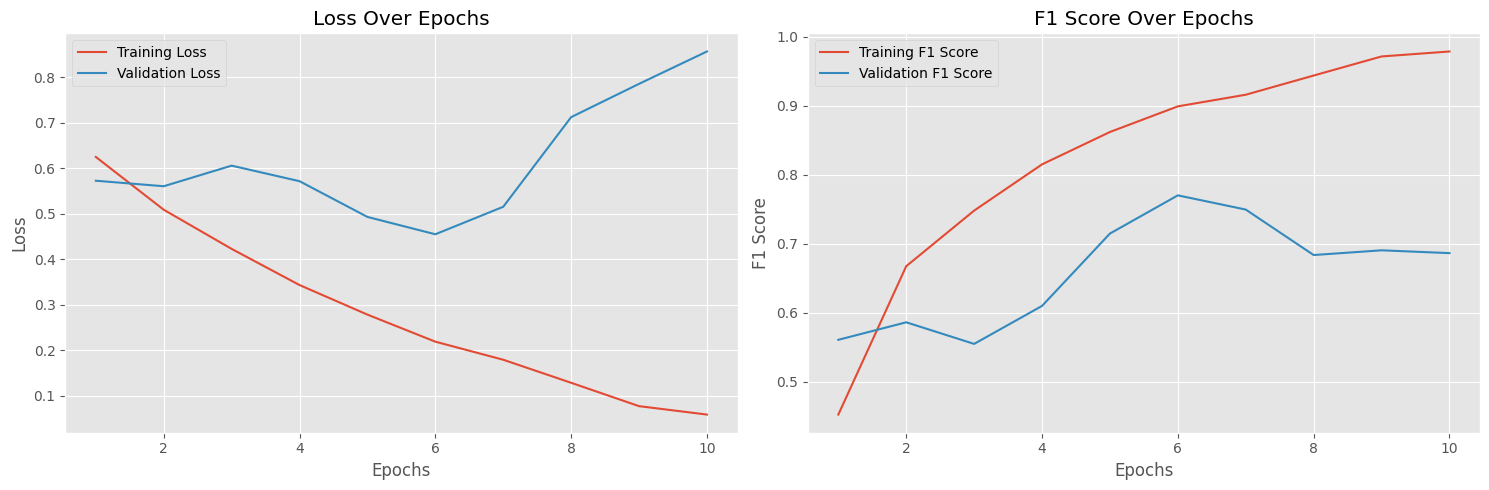

In [70]:
history_baseline_lem = train_model(Baseline,
                               embedding_dimension,
                               dataset_type='lem',
                               learning_rate=0.001,
                               checkpoint_filepath='baseline_lem.weights.h5',
                               epochs=10,
                               batch_size=32,
                               seeds=[42,100,666],
                               embedding_trainable=True)
plot_training(history_baseline_lem, evaluation=True)

In [80]:
print(f"F1-Score on validation set: {round(history_baseline_lem['val_f1_score'], 3)}")
print(f"F1-Score on test set: {round(history_baseline_lem['test_f1_score'], 3)}")

F1-Score on validation set: 0.749
F1-Score on test set: 0.732


#### Baseline - lemmatized text with no stopwords

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 0.6309 - precision: 0.5763 - recall: 0.4098 - val_loss: 0.5428 - val_precision: 0.7907 - val_recall: 0.5000
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.4971 - precision: 0.7173 - recall: 0.6452 - val_loss: 0.5227 - val_precision: 0.8333 - val_recall: 0.5147
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.4110 - precision: 0.7892 - recall: 0.7375 - val_loss: 0.5311 - val_precision: 0.8537 - val_recall: 0.5147
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.3225 - precision: 0.8520 - recall: 0.8098 - val_loss: 0.5774 - val_precision: 0.8222 - val_recall: 0.5441
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.2291 - precision: 0.8986 - recall: 0.8930 - val_loss: 0.6629 - val_precision: 0.7872 - val_recall: 0.5441
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1549 - precision: 0.9340 - recall: 0.9347 - val_loss: 0.7771 - val_precision: 0.8537 - val_recall: 0.51

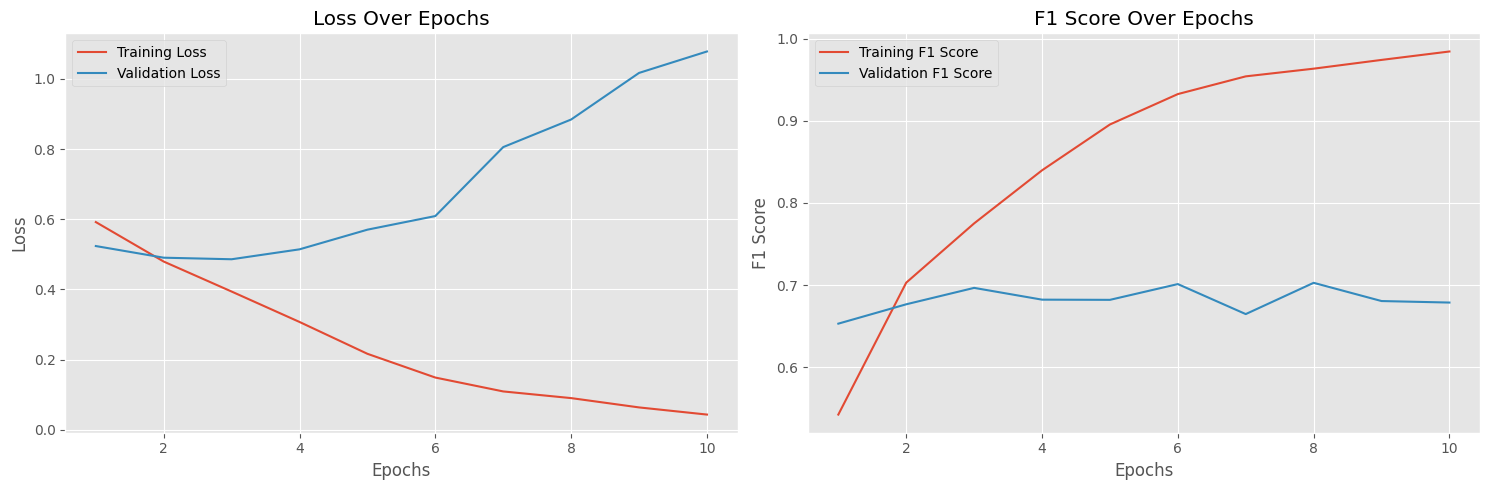

In [72]:
history_baseline_no_stop = train_model(Baseline,
                               embedding_dimension,
                               dataset_type='no_stop',
                               learning_rate=0.001,
                               checkpoint_filepath='baseline_no_stop.weights.h5',
                               epochs=10,
                               batch_size=32,
                               seeds=[42,100,666],
                               embedding_trainable=True)
plot_training(history_baseline_no_stop, evaluation=True)

In [81]:
print(f"F1-Score on validation set: {round(history_baseline_no_stop['val_f1_score'], 3)}")
print(f"F1-Score on test set: {round(history_baseline_no_stop['test_f1_score'], 3)}")

F1-Score on validation set: 0.706
F1-Score on test set: 0.727


#### Baseline - simple processed text

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.6518 - precision: 0.5188 - recall: 0.2839 - val_loss: 0.5650 - val_precision: 0.8000 - val_recall: 0.4706
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.5153 - precision: 0.6968 - recall: 0.6410 - val_loss: 0.5231 - val_precision: 0.9189 - val_recall: 0.5000
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.4186 - precision: 0.7865 - recall: 0.7199 - val_loss: 0.5530 - val_precision: 0.9143 - val_recall: 0.4706
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.3363 - precision: 0.8485 - recall: 0.7788 - val_loss: 0.5039 - val_precision: 0.8511 - val_recall: 0.5882
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.2510 - precision: 0.8805 - recall: 0.8546 - val_loss: 0.4607 - val_precision: 0.7966 - val_recall: 0.6912
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.2038 - precision: 0.9090 - recall: 0.9007 - val_loss: 0.4836 - val_precision: 0.8070 - val_recall: 0.67

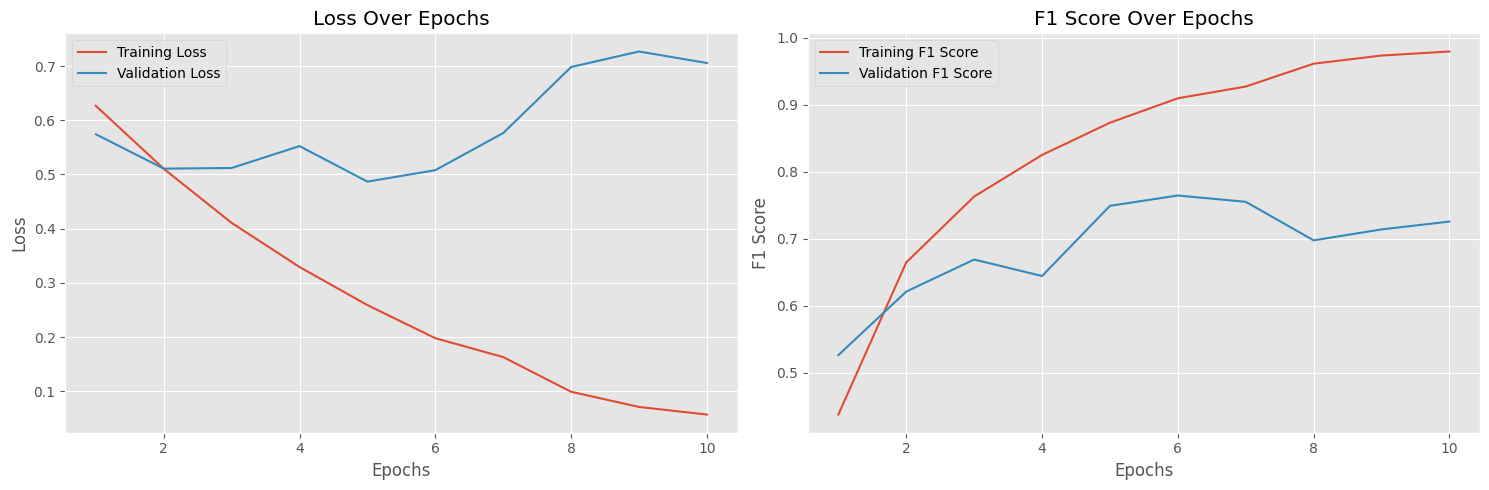

In [74]:
history_baseline_simple = train_model(Baseline,
                               embedding_dimension,
                               dataset_type='simple',
                               learning_rate=0.001,
                               checkpoint_filepath='baseline_simple.weights.h5',
                               epochs=10,
                               batch_size=32,
                               seeds=[42,100,666],
                               embedding_trainable=True)
plot_training(history_baseline_simple, evaluation=True)

In [82]:
print(f"F1-Score on validation set: {round(history_baseline_simple['val_f1_score'], 3)}")
print(f"F1-Score on test set: {round(history_baseline_simple['test_f1_score'], 3)}")

F1-Score on validation set: 0.752
F1-Score on test set: 0.731


For the baseline model, we have the best results for the lemmatized text, with 0.732 of F1-Score.

#### Model1 - lemmatized text

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - loss: 0.6337 - precision: 0.5436 - recall: 0.3034 - val_loss: 0.5867 - val_precision: 0.8485 - val_recall: 0.4118
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - loss: 0.5126 - precision: 0.7002 - recall: 0.6188 - val_loss: 0.5252 - val_precision: 0.8462 - val_recall: 0.4853
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - loss: 0.4260 - precision: 0.7814 - recall: 0.7142 - val_loss: 0.5186 - val_precision: 0.8298 - val_recall: 0.5735
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - loss: 0.3433 - precision: 0.8208 - recall: 0.7893 - val_loss: 0.5990 - val_precision: 0.8298 - val_recall: 0.5735
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.2657 - precision: 0.8643 - recall: 0.8651 - val_loss: 0.7663 - val_precision: 0.8485 - val_recall: 0.4118
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - loss: 0.1946 - precision: 0.9125 - recall: 0.9025 - val_loss: 0.4999 - val_precision: 0.7885 - val_r

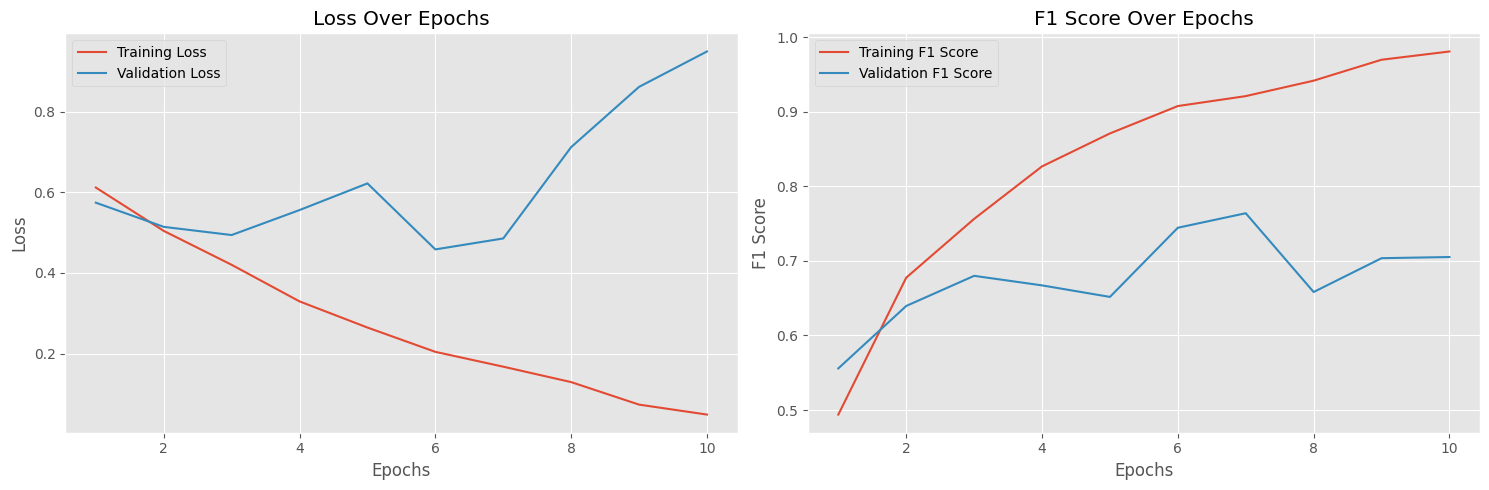

In [67]:
history_model1_lem = train_model(Model1,
                             embedding_dimension,
                             dataset_type='lem',
                             learning_rate=0.001,
                             checkpoint_filepath='model1_lem.weights.h5',
                             epochs=10,
                             batch_size=32,
                             seeds=[42,100,666],
                             embedding_trainable=True)
plot_training(history_model1_lem, evaluation=True)

In [83]:
print(f"F1-Score on validation set: {round(history_model1_lem['val_f1_score'], 3)}")
print(f"F1-Score on test set: {round(history_model1_lem['test_f1_score'], 3)}")

F1-Score on validation set: 0.799
F1-Score on test set: 0.777


#### Model1 - lemmatized text with no stopwords

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - loss: 0.6119 - precision: 0.5677 - recall: 0.3854 - val_loss: 0.5342 - val_precision: 0.8372 - val_recall: 0.5294
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.4954 - precision: 0.7283 - recall: 0.6324 - val_loss: 0.5250 - val_precision: 0.8605 - val_recall: 0.5441
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.4177 - precision: 0.7964 - recall: 0.7225 - val_loss: 0.5330 - val_precision: 0.8723 - val_recall: 0.6029
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.3304 - precision: 0.8422 - recall: 0.8127 - val_loss: 0.5538 - val_precision: 0.8163 - val_recall: 0.5882
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 0.2226 - precision: 0.8941 - recall: 0.8988 - val_loss: 0.6063 - val_precision: 0.7925 - val_recall: 0.6176
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.1396 - precision: 0.9408 - recall: 0.9395 - val_loss: 0.7919 - val_precision: 0.7400 - val_r

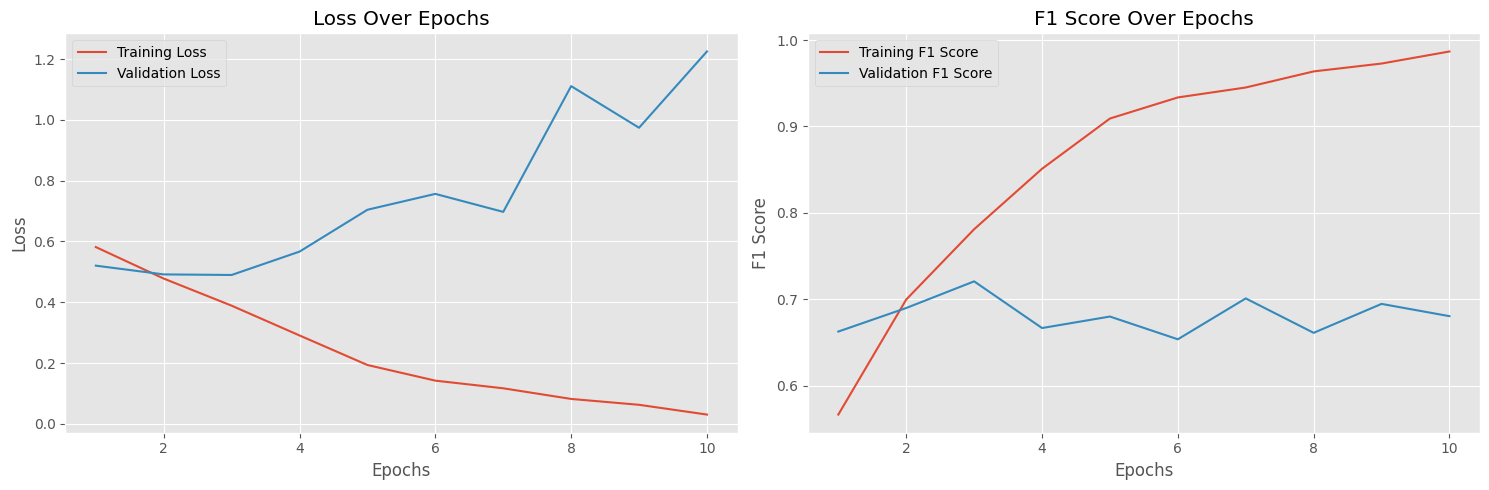

In [76]:
history_model1_no_stop = train_model(Model1,
                             embedding_dimension,
                             dataset_type='no_stop',
                             learning_rate=0.001,
                             checkpoint_filepath='model1_no_stop.weights.h5',
                             epochs=10,
                             batch_size=32,
                             seeds=[42,100,666],
                             embedding_trainable=True)
plot_training(history_model1_no_stop, evaluation=True)

In [84]:
print(f"F1-Score on validation set: {round(history_model1_no_stop['val_f1_score'], 3)}")
print(f"F1-Score on test set: {round(history_model1_no_stop['test_f1_score'], 3)}")

F1-Score on validation set: 0.695
F1-Score on test set: 0.723


#### Model1 - simple processed text

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - loss: 0.6352 - precision: 0.5457 - recall: 0.3021 - val_loss: 0.5666 - val_precision: 0.8889 - val_recall: 0.4706
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - loss: 0.5035 - precision: 0.7137 - recall: 0.6528 - val_loss: 0.5592 - val_precision: 0.9429 - val_recall: 0.4853
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 0.4049 - precision: 0.7974 - recall: 0.7438 - val_loss: 0.5129 - val_precision: 0.8163 - val_recall: 0.5882
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - loss: 0.2983 - precision: 0.8621 - recall: 0.8379 - val_loss: 0.5662 - val_precision: 0.8511 - val_recall: 0.5882
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - loss: 0.2247 - precision: 0.8946 - recall: 0.8996 - val_loss: 0.7511 - val_precision: 0.8611 - val_recall: 0.4559
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - loss: 0.1756 - precision: 0.9199 - recall: 0.9154 - val_loss: 0.4539 - val_precision: 0.7971 - val_r

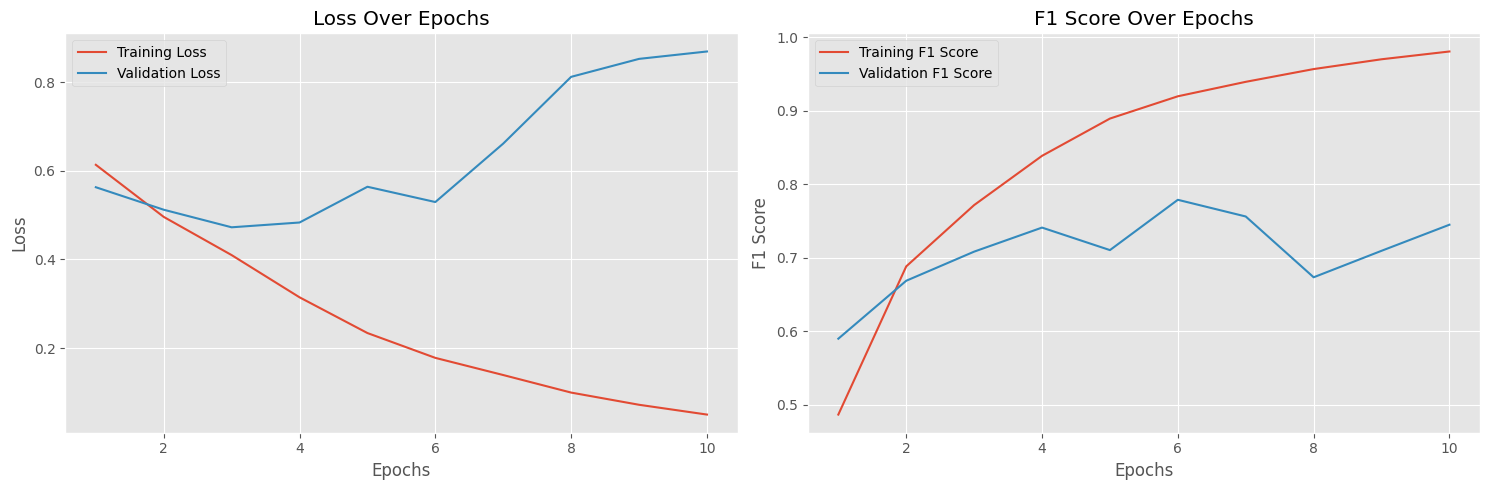

In [78]:
history_model1_simple = train_model(Model1,
                             embedding_dimension,
                             dataset_type='simple',
                             learning_rate=0.001,
                             checkpoint_filepath='model1_simple.weights.h5',
                             epochs=10,
                             batch_size=32,
                             seeds=[42,100,666],
                             embedding_trainable=True)
plot_training(history_model1_simple, evaluation=True)

In [85]:
print(f"F1-Score on validation set: {round(history_model1_simple['val_f1_score'], 3)}")
print(f"F1-Score on test set: {round(history_model1_simple['test_f1_score'], 3)}")

F1-Score on validation set: 0.784
F1-Score on test set: 0.758


For Model1, we have again the best results for the lemmatized text, with 0.777 of F1-Score on the test-set.

## 6. Transformers

In this section, we will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate) from HuggingFace.

In [ ]:
model_card = 'cardiffnlp/twitter-roberta-base-hate'

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

We will repeat the experiment with the transformer architecture; we will start with the simple processed tweets this time, since we expect that the architecture can make the best use of the attention mechanism inside a more expressive text. We will then try the other processing techniques in order to compre the results.

In [ ]:
from datasets import Dataset

def create_transformer_dataset(columns_to_drop, tweet_column, dfs):
    train_data = Dataset.from_pandas(dfs[0].drop(columns=columns_to_drop))
    val_data = Dataset.from_pandas(dfs[1].drop(columns=columns_to_drop))
    test_data = Dataset.from_pandas(dfs[2].drop(columns=columns_to_drop))
    return train_data, val_data, test_data

In [50]:
df_train_filtered.head()

,id_EXIST,lang,tweet,hard_label_task1,lemmatized_tweet,lemmatized_no_stopwords_tweet,simple_processed_tweet
200002,200002,en,Writing a uni essay in my local pub with a cof...,1,write a uni essay in my local pub with a coffe...,write uni essay local pub coffee random old ma...,writing a uni essay in my local pub with a cof...
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1,<USER> it be <NUMBER> not <NUMBER> i do not ap...,<USER> <NUMBER> <NUMBER> appreciate ride team ...,<USER> it is <NUMBER> not <NUMBER> i do not ap...
200006,200006,en,According to a customer I have plenty of time ...,1,accord to a customer i have plenty of time to ...,accord customer plenty time spend stirling coi...,according to a customer i have plenty of time ...
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1,so only blokes drink beer sorry but if you be ...,bloke drink beer sorry bloke drink wine appare...,so only blokes drink beer sorry but if you are...
200008,200008,en,New to the shelves this week - looking forward...,0,new to the shelf this week look forward to rea...,new shelf week look forward read book <USER> <...,new to the shelves this week looking forward t...


#### Simple processed tweets 


Let's build the simple processed dataset

In [51]:
columns_to_drop = ['tweet', 'lemmatized_tweet', 'lemmatized_no_stopwords_tweet']
tweet_column = 'simple_processed_tweet'
train_data, val_data, test_data = create_transformer_dataset(columns_to_drop,
                                                             tweet_column,
                                                             [df_train_filtered,
                                                              df_val_filtered,
                                                              df_test_filtered])

Let's define the tokenizer of our model

In [52]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_card)

def tokenize_text(texts):
    return tokenizer(texts[tweet_column], truncation=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Tokenization of the dataset according to the model tokenizator

In [53]:
train_data = train_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)
val_data = val_data.map(tokenize_text, batched=True)

print(train_data)
print(test_data)
print(val_data)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'hard_label_task1', 'simple_processed_tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})
Dataset({
    features: ['id_EXIST', 'lang', 'hard_label_task1', 'simple_processed_tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 286
})
Dataset({
    features: ['id_EXIST', 'lang', 'hard_label_task1', 'simple_processed_tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 158
})


In [55]:
original_text = train_data[tweet_column][5]
decoded_text = tokenizer.decode(train_data['input_ids'][5])

print(original_text)
print()
print()
print(decoded_text)

i guess that is fairly normal for a neanderthal <URL>


<s>i guess that is fairly normal for a neanderthal <URL></s>


Since we subsituted some words with special tokens we will add them into the transformer vocabulary!

In [56]:
special_tokens = ["<URL>", "<HASHTAG>","<USER>","<EMOJI>","<NUMBER>"]
num_added_tokens = tokenizer.add_tokens(special_tokens)
print(f"Added {num_added_tokens} new tokens to the tokenizer.")

Added 5 new tokens to the tokenizer.


Let's take a look at how the transformer tokenize a tweet example.

In [57]:
tokenizer.tokenize(original_text)

['i',
 'Ġguess',
 'Ġthat',
 'Ġis',
 'Ġfairly',
 'Ġnormal',
 'Ġfor',
 'Ġa',
 'Ġne',
 'ander',
 'thal',
 'Ġ',
 '<URL>']

The special character handles the space character.

We are ready to define our model

In [59]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NO', 1: 'YES'}, label2id={'NO': 0, 'YES': 1})

print(model)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Since we added special tokens, we call the following method to assign an embedding to the freshly added tokens

In [60]:
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50270, 768, padding_idx=1)

In [64]:
train_data = train_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')
val_data = val_data.rename_column('hard_label_task1', 'label')


Let's start the training.

In [65]:
from transformers import TrainingArguments
from sklearn.model_selection import ParameterGrid
from transformers import Trainer, DataCollatorWithPadding

learning_rate=1e-5
batch_size=32
num_train_epochs=5
weight_decay=0.1

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,         # batch size
    per_device_eval_batch_size=batch_size,          # batch size
    num_train_epochs=num_train_epochs,             # number of epochs
    weight_decay=weight_decay,
    eval_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    metric_for_best_model="f1",      # Specify the metric to determine the best model
    greater_is_better=True,
    logging_strategy="epoch",
    report_to='none'                      # disabling wandb (default)
    )

trainer_simple = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_data,
  eval_dataset=val_data,
  processing_class=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

history = trainer_simple.train()

metrics = trainer_simple.evaluate()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.420000,0.333093,0.883824,0.886076
2,0.312200,0.352046,0.868003,0.873418
3,0.246000,0.335284,0.889169,0.892405
4,0.208600,0.395446,0.880544,0.886076
5,0.181600,0.392122,0.887497,0.892405


In [66]:
test_prediction_info = trainer_simple.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
test_metrics = compute_metrics([test_predictions, test_labels])
cm_simple = confusion_matrix(y_test, np.argmax(test_predictions, axis=-1), labels=[0, 1], normalize='true')
print(f"f1 on the test set: {round(test_metrics['f1'], 3)}")
print(f"accuracy on the test set: {round(test_metrics['acc'], 3)}")

f1 on the test set: 0.845
accuracy on the test set: 0.846


#### Lemmatized tweed
Let's repeat the experiment with lemmatized tweets    

In [67]:
columns_to_drop = ['tweet', 'simple_processed_tweet', 'lemmatized_no_stopwords_tweet']
tweet_column = 'lemmatized_tweet'
train_data, val_data, test_data = create_transformer_dataset(columns_to_drop,
                                                             tweet_column,
                                                             [df_train_filtered,
                                                              df_val_filtered,
                                                              df_test_filtered])
tokenizer = AutoTokenizer.from_pretrained(model_card)

train_data = train_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)
val_data = val_data.map(tokenize_text, batched=True)

num_added_tokens = tokenizer.add_tokens(special_tokens)

model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NO', 1: 'YES'}, label2id={'NO': 0, 'YES': 1})
model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_data = train_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')
val_data = val_data.rename_column('hard_label_task1', 'label')

training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,         # batch size
    per_device_eval_batch_size=batch_size,          # batch size
    num_train_epochs=num_train_epochs,             # number of epochs
    weight_decay=weight_decay,
    eval_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    metric_for_best_model="f1",      # Specify the metric to determine the best model
    greater_is_better=True,
    logging_strategy="epoch",
    report_to='none'                      # disabling wandb (default)
    )

trainer_lem = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_data,
  eval_dataset=val_data,
  processing_class=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

history = trainer_lem.train()

metrics = trainer_lem.evaluate()

test_prediction_info = trainer_lem.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
test_metrics = compute_metrics([test_predictions, test_labels])
cm_lem = confusion_matrix(y_test, np.argmax(test_predictions, axis=-1), labels=[0, 1], normalize='true')
print(f"f1 on the test set: {round(test_metrics['f1'], 3)}")
print(f"accuracy on the test set: {round(test_metrics['acc'], 3)}")

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.420000,0.334650,0.875554,0.879747
2,0.318200,0.332671,0.894947,0.898734
3,0.258600,0.321311,0.895451,0.898734
4,0.209300,0.393729,0.893817,0.898734
5,0.188400,0.399821,0.879838,0.886076


f1 on the test set: 0.856
accuracy on the test set: 0.857


#### Lemmatized tweets with no stopwords

In [68]:
columns_to_drop = ['tweet', 'lemmatized_tweet', 'simple_processed_tweet']
tweet_column = 'lemmatized_no_stopwords_tweet'
train_data, val_data, test_data = create_transformer_dataset(columns_to_drop,
                                                             tweet_column,
                                                             [df_train_filtered,
                                                              df_val_filtered,
                                                              df_test_filtered])
tokenizer = AutoTokenizer.from_pretrained(model_card)

train_data = train_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)
val_data = val_data.map(tokenize_text, batched=True)

num_added_tokens = tokenizer.add_tokens(special_tokens)

model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NO', 1: 'YES'}, label2id={'NO': 0, 'YES': 1})
model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_data = train_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')
val_data = val_data.rename_column('hard_label_task1', 'label')

training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,         # batch size
    per_device_eval_batch_size=batch_size,          # batch size
    num_train_epochs=num_train_epochs,             # number of epochs
    weight_decay=weight_decay,
    eval_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    metric_for_best_model="f1",      # Specify the metric to determine the best model
    greater_is_better=True,
    logging_strategy="epoch",
    report_to='none'                      # disabling wandb (default)
    )

trainer_no_stop = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_data,
  eval_dataset=val_data,
  processing_class=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

history = trainer_no_stop.train()

metrics = trainer_no_stop.evaluate()

test_prediction_info = trainer_no_stop.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
test_metrics = compute_metrics([test_predictions, test_labels])
cm_no_stop = confusion_matrix(y_test, np.argmax(test_predictions, axis=-1), labels=[0, 1], normalize='true')
print(f"f1 on the test set: {round(test_metrics['f1'], 3)}")
print(f"accuracy on the test set: {round(test_metrics['acc'], 3)}")

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.453800,0.378958,0.823974,0.829114
2,0.363100,0.364311,0.830108,0.835443
3,0.310800,0.406377,0.834555,0.841772
4,0.269600,0.454906,0.832592,0.841772
5,0.236100,0.430167,0.841604,0.848101


f1 on the test set: 0.813
accuracy on the test set: 0.815


Our pre-trained transformer outperformed our customs model with every dataset; the best performance were surprisingly obtained again on the lemmatized tweets, with an F1-Score of 0.856 on the test-set

## 7. Error Analysis
### In this section we discuss the results, the identified problems and some suggestion to address those errors.
#### 1. Data:  
- In the cleaning part of the data we dropped about 25% of the tweets that were "ambiguous"; those data definetly contributed to the learning process of our model. We could have disambiguated the label with random sampling, or by labelling them with human intervention (even tho it is quite expensive) and see the impact.
- Data umbalance might be another factor that contributed on performances; our model might have learned that SEXIST comment are less frequent than NON SEXIST.  
As we can see from the confusion matrices below, this is not really the case since we are able to give prediction (in percentage) of SEXIST and NON-SEXIST tweets almost in the same way. We could either way have measured the impact by using techniques such as weight sampling or data augmentation techniques.
#### 2. Cleaning process and OOV WORDS:
It is quite clear that the quality of the tweets affects the performances of our models; in all of them we achieved the best performance on the **lemmatized tweet**, while the worst have been reached with **lemmatized tweets without stopwords**. This might be the case because the text was not expressive enough to capture a global semantic. It is worth to note that the performances on **simple processed tweets** were comparable with the ones achieved with **lemmatized_tweets**, and they increased with Model1 and Transformer architecture.  

Our simple regular expressions were not able to fully clean our tweets from ambiguous text; we could have experimented more sophisticated data cleaning techniques in order to reduce the number of OOV terms, such as word separation (in case of words not spaced) and letter repetitions cleaning. Remeber: data cleaning is (one of) the **most important** part of every AI task!  

**Example** of a tweet that contains several OOV terms

In [148]:
idx = 200830
print(f"original tweet: {df_train_filtered['tweet'].loc[idx]}")
print(f"lemmatized tweet: {df_train_filtered['lemmatized_tweet'].loc[idx]}")
print(f"OOV terms: {set(check_OOV_terms(embedding_model, df_train_filtered['lemmatized_tweet'].loc[idx].split())).difference(set(special_tokens))}")


original tweet: @BiggBoss_Tak Empower Fakesswi Andhkaar 😂🤣🤣🤣For what?! Already bohot “empowered” woman hai ULTIMATE BOSS KARAN Season Pandra! Karan Kundrra! #KaranIsTheBoss King @kkundrra@OrmaxMedia #BBKingKaran#KaranKundrra #KKundrraSquad #BiggBoss @justvoot @VootSelect
lemmatized tweet: <USER> empower fakesswi andhkaar <EMOJI> for what already bohot empower woman hai ultimate bos karan season pandra karan kundrra <HASHTAG> king <USER> <HASHTAG> <HASHTAG> <HASHTAG> <USER> <USER>
OOV terms: {'bohot', 'kundrra', 'fakesswi', 'andhkaar', 'pandra'}


as we can see it contains several "Hindi" term and references to a very specific concept, for which there is no explicit information. Those terms are not part of the english language and especially of the GloVE vocabulary. Tweets like this inject irrelevant knowledge and add noise to the training process, making it difficult even for humans to classify the text.

#### 3. Text encoding:
We haven't experimented much with embedding methods and size of the representation. Hyperparams tuning is always crucial to improve solutions, but most of our models reached overfitting quite early during training (we will discuss about this in the next section); using a bigger embedding dimension then might have just introduced overhead to the computation (in terms of data representation and flops)! But it would have been worth to try it.
#### 4. Models:
- **Baseline vs Model1**. By studying the learning curves, we see a similar learning trend, but we definetly reach a better f1-score in the test set with Model1. One thing is worth to notice from the confusion matrices below is that Model1 is able to increase the number of positive (Sexist) predictions. We can interpret this by saying that the model have reduced the bias introduced by the dataset's imbalanced.
- **roBERTa Transformer**. What we said for Model1 is especially true for the transformer architecture; This time we've been able to reduce **both** false positive and false negative and we have achieved the best results with this model, again on the lemmatized tweets. Attention mechanisms is all we need!
- **General considerations**. Using more complex models helped us in reducing bias and better understanding more complex text.  Hyperparameters tuning is another very important step in the training process! We could have experimented more with learning rate, batch size and optimizers...  But to solve overfitting, all we need are regularization techniques!! Drop out layers, learning rate schedulers and weight decays are things we could have tried on our models to see if we could have improved performances.

#### Confusion matrices of our models for advanced analysis and to extract better insights

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


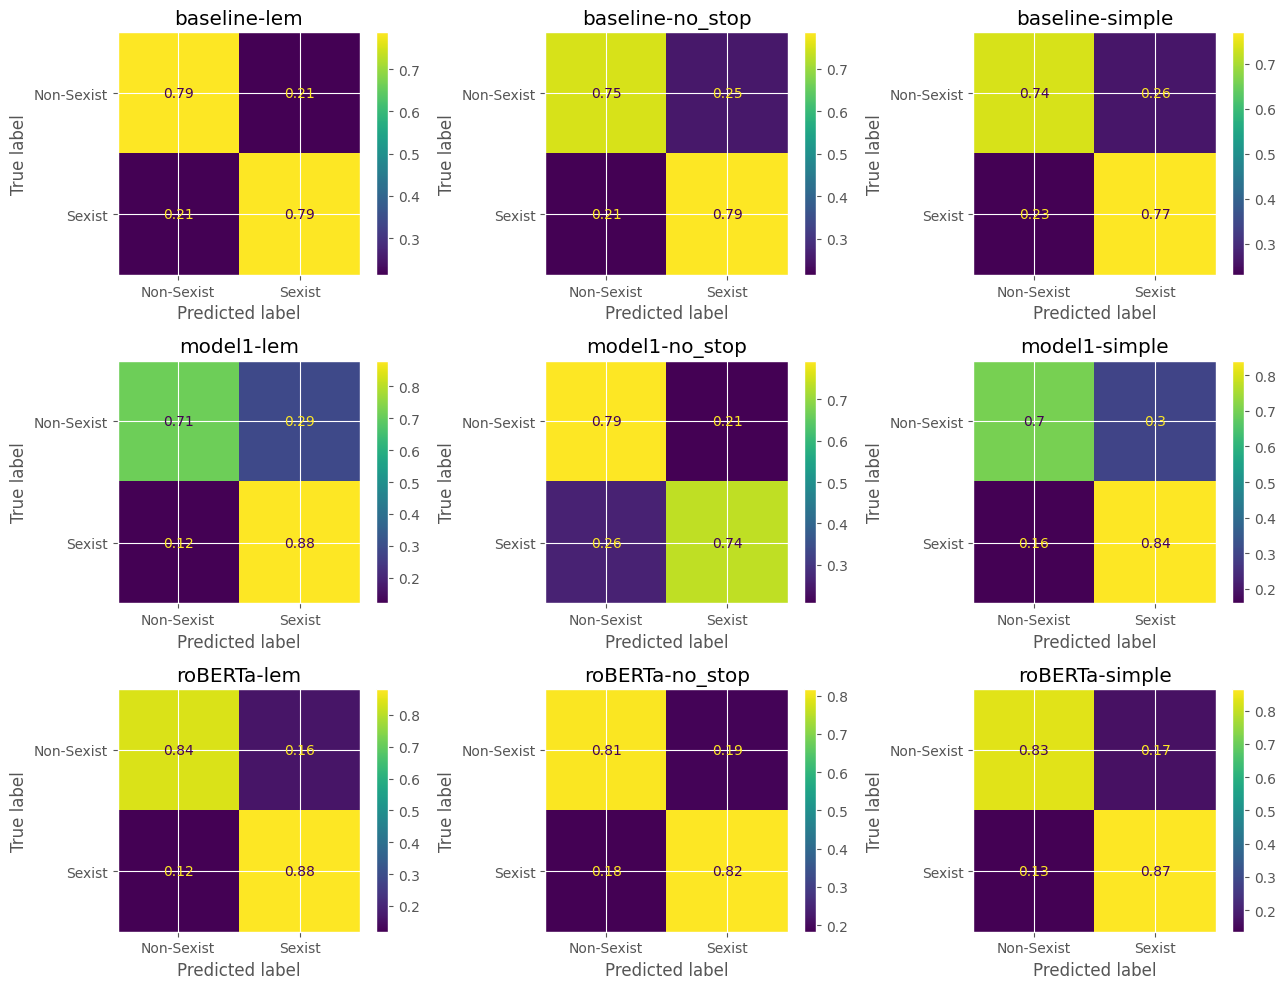

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(13, 10))
for r, class_model in enumerate([Baseline, Model1]):
    for c, dataset_type in enumerate(['lem', 'no_stop', 'simple']):
        X_test = X_test_lem if dataset_type == 'lem' else X_test_no_stop if dataset_type == 'no_stop' else X_test_simple
        checkpoint_filepath = f'{class_model.__name__.lower()}_{dataset_type}.weights.h5'
        model = load_model_weights(class_model, checkpoint_filepath, dataset_type)
        cm = confusion_matrix(y_test, model.predict(X_test) > 0.5, labels=[0, 1], normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Sexist', 'Sexist'], )
        disp.plot(ax=axs[r, c])
        axs[r, c].title.set_text(f'{class_model.__name__.lower()}-{dataset_type}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lem, display_labels=['Non-Sexist', 'Sexist'], )
disp.plot(ax=axs[2, 0])
axs[2, 0].title.set_text("roBERTa-lem")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_no_stop, display_labels=['Non-Sexist', 'Sexist'], )
disp.plot(ax=axs[2, 1])
axs[2, 1].title.set_text("roBERTa-no_stop")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_simple, display_labels=['Non-Sexist', 'Sexist'], )
disp.plot(ax=axs[2, 2])
axs[2, 2].title.set_text("roBERTa-simple")

plt.tight_layout()
plt.show()

The confusion matrices provide even better insight into what our models improved in; focusing on the datasets that provided the best results (lem, simple) we can see how models with increasing complexity increased the percentage of positive (Sexist) predictions, reducing the bias introduced by the dataset’s imbalance, and how the transformer architecture was able to reduce both false negative and false positive with respect to the baseline.

#### 5. Conclusions:
To conclude the error analysis, we can summarize that text processing plays an important role even using the same models; transformer architecture outperformed on this classification tasks, while our custom models could have been improved with hyperparams tuning and regularization techniques!





# The End